In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def inv_boxcox(y_boxcox, lambda_):
    """Inverse Box-Cox transformation"""
    if lambda_ == 0:
        return np.exp(y_boxcox)
    else:
        return np.power(y_boxcox * lambda_ + 1, 1 / lambda_)


## 1. Read, clean & explore the data

In [102]:
# Read the data 
data_df = pd.read_csv('data/insurance.csv')
data_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [103]:
# Check for missing values
data_df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Luckily we have no missing data, proceeding to look at distribution of numerical and categorical features

In [104]:
# Check for distribution of numerical features
data_df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [105]:
# Get summary of categorical features
data_df.describe(include=['O'])

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


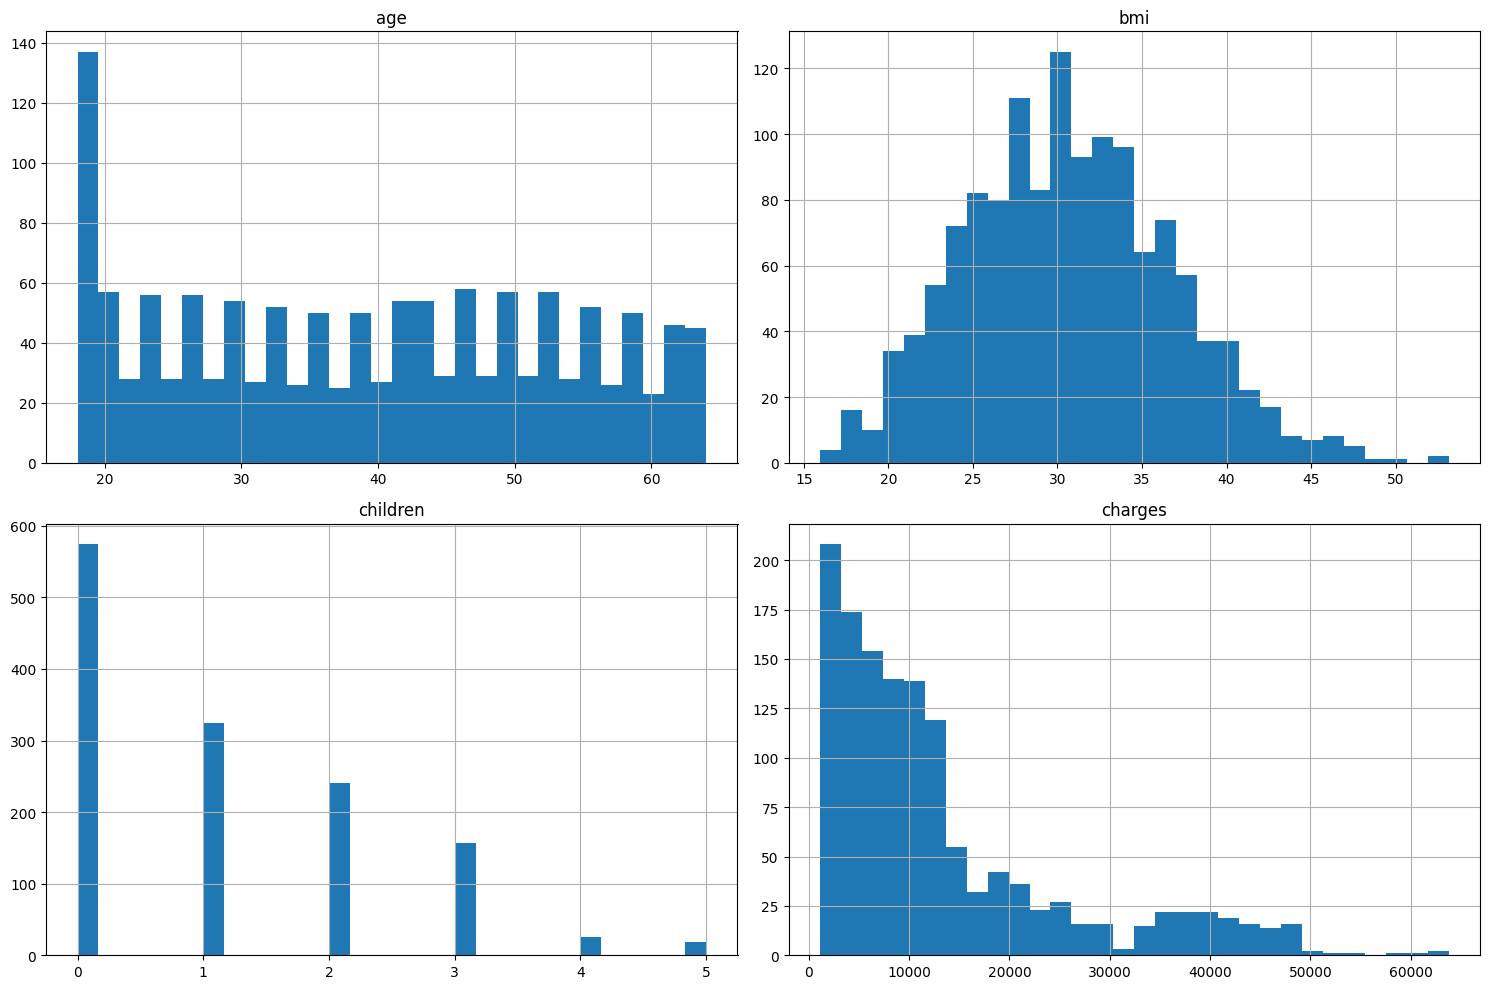

In [106]:
# Plot a grid of histograms of charges and the other features to see their distributions
data_df.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

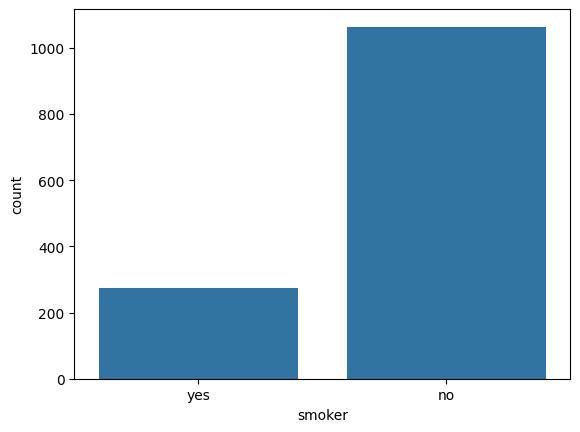

smoker
no     1064
yes     274
Name: count, dtype: int64


In [107]:
# Distribution of smokers vs non-smokers
sns.countplot(x='smoker', data=data_df)
plt.show()

# print counts of smokers and non-smokers
print(data_df['smoker'].value_counts())

Data is right-skewed for charges. Proceed to use Box-Cox.

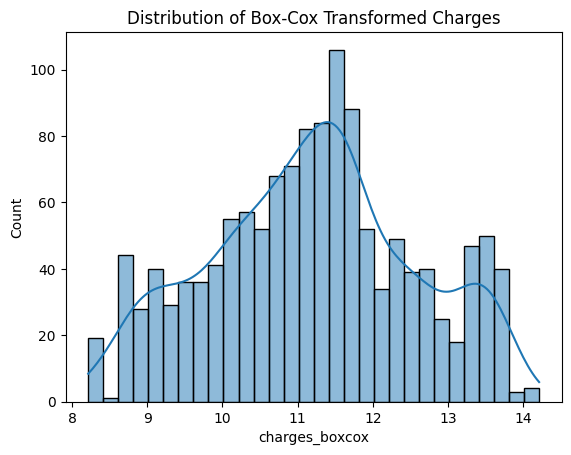

In [108]:
# Transform the charges using box-cox transformation to reduce skewness and plot the distribution
from scipy import stats
data_df['charges_boxcox'], fitted_lambda = stats.boxcox(data_df['charges'] + 1)  # Adding 1 to avoid issues with zero values
sns.histplot(data_df['charges_boxcox'], bins=30, kde=True)
plt.title('Distribution of Box-Cox Transformed Charges')
plt.show()

The distribution still isn't quite normal - we can leverage boxcox for linear regression and use raw charges with a suitable objective metric for the ensemble models as ensemble models can derive complex relationships using attributes that aren't normalized.

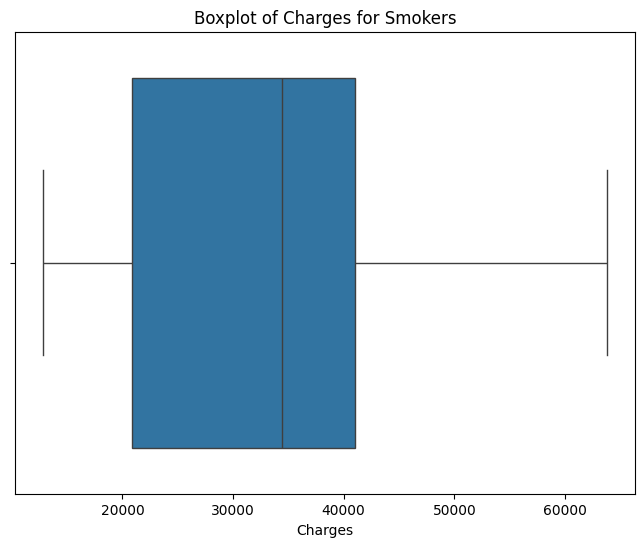

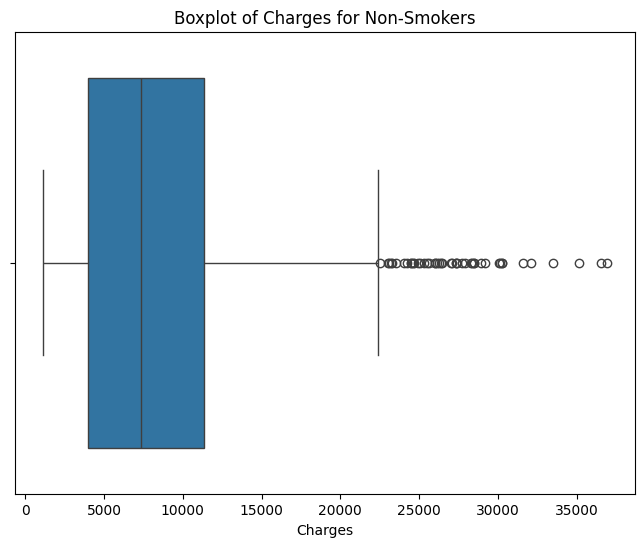

In [109]:
# Look at smoking status separately
smoker_df = data_df[data_df['smoker'] == 'yes']
non_smoker_df = data_df[data_df['smoker'] == 'no']

plt.figure(figsize=(8, 6))
sns.boxplot(x=smoker_df['charges'])
plt.title('Boxplot of Charges for Smokers')
plt.xlabel('Charges')
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x=non_smoker_df['charges'])
plt.title('Boxplot of Charges for Non-Smokers')
plt.xlabel('Charges')
plt.show()

Smoking status has a strong association with charges; there are multiple outliers in non-smokers.

In [110]:
# Count the number of outliers in charges for non-smoker group
Q1 = non_smoker_df['charges'].quantile(0.25)
Q3 = non_smoker_df['charges'].quantile(0.75)
IQR = Q3 - Q1
outliers = non_smoker_df[(non_smoker_df['charges'] < (Q1 - 1.5 * IQR)) | (non_smoker_df['charges'] > (Q3 + 1.5 * IQR))]
print(f'Number of outliers in charges for non-smoker group: {outliers.shape[0]}')

# Drop the outliers from non-smoker group
data_df = data_df[~data_df.index.isin(outliers.index)]
data_df.reset_index(drop=True, inplace=True)
data_df.shape

Number of outliers in charges for non-smoker group: 46


(1292, 8)

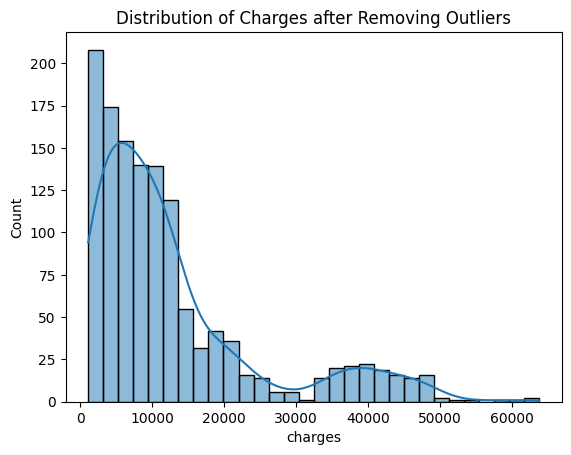

In [111]:
# Print distribution of charges after removing outliers
sns.histplot(data_df['charges'], bins=30, kde=True)
plt.title('Distribution of Charges after Removing Outliers')
plt.show()

## 2. Scaling, normalizing & correlating the data

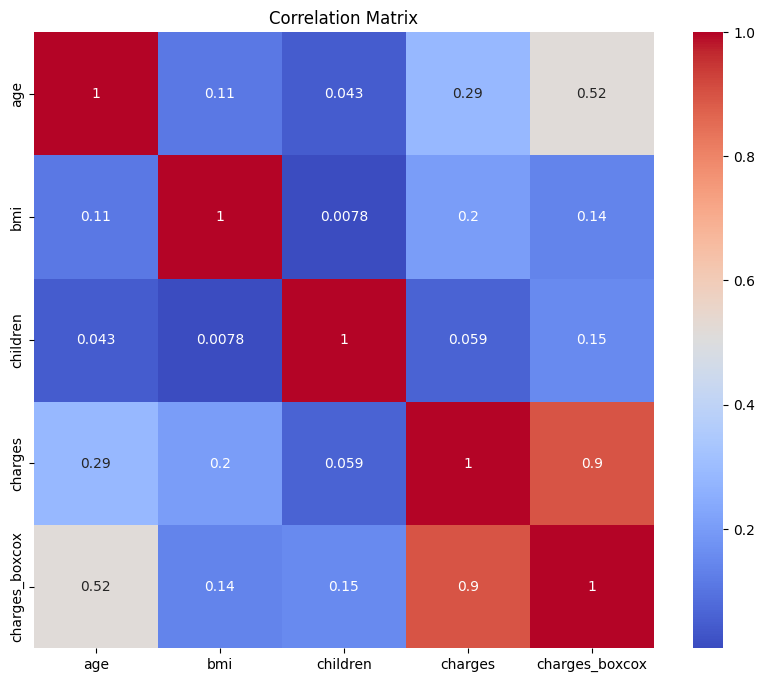

In [112]:
# Plot correlation heatmap

plt.figure(figsize=(10, 8))
# Only numerical features are considered for correlation
numerical_features = data_df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = data_df[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## 4. Baseline model - Simple linear regression

In [113]:
# Model the relationship between charges (y) and the other features (X) using simple linear regression 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
# Define features and target variable
X = data_df.drop('charges_boxcox', axis=1)
y = data_df['charges_boxcox']
# One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)
# Use train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Use 10 fold cross-validation to evaluate the model
from sklearn.model_selection import cross_val_score
model = LinearRegression()
mse_scores = -cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(mse_scores)
r2_scores = cross_val_score(model, X_train, y_train, cv=10, scoring='r2')
print(f'Average RMSE from 10-fold CV: {rmse_scores.mean():.6f}')
print(f'Average R² from 10-fold CV: {r2_scores.mean():.6f}')
# Fit the model on the training data
model.fit(X_train, y_train)
# Predict on the test data
y_pred = model.predict(X_test)
# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f'Test RMSE: {mse:.6f}')
print(f'Test R²: {r2:.6f}')

Average RMSE from 10-fold CV: 0.426046
Average R² from 10-fold CV: 0.900810
Test RMSE: 9698330.851530
Test R²: 0.893350


In [114]:
# scale R2 and RMSE back to original charges
y_test_orig = inv_boxcox(y_test, fitted_lambda)
y_pred_orig = inv_boxcox(y_pred, fitted_lambda)
rmse_orig = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
ss_total = np.sum((y_test_orig - np.mean(y_test_orig)) ** 2)
ss_residual = np.sum((y_test_orig - y_pred_orig) ** 2)
r2_orig = 1 - (ss_residual / ss_total)
print(f'Test RMSE (original charges): {rmse_orig:.2f}') 
print(f'Test R² (original charges): {r2_orig:.6f}')

Test RMSE (original charges): 9037.07
Test R² (original charges): 0.427775


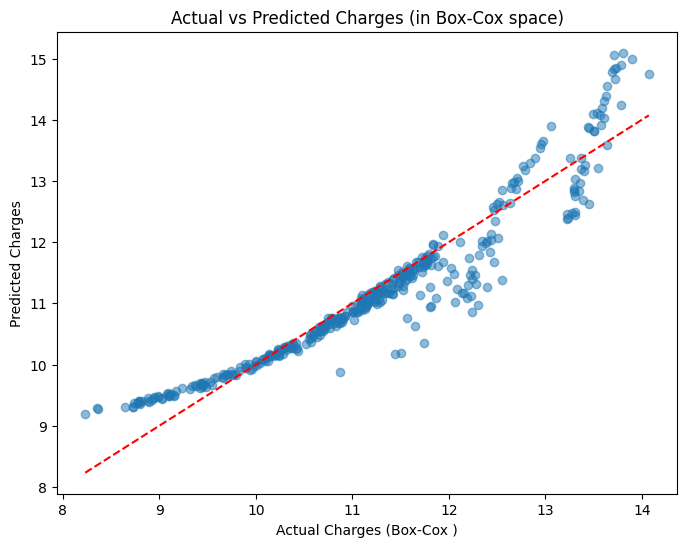

In [115]:
# Make a scatter plot of model predicted charges vs actual charges (in the Box-Cox space)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Charges (Box-Cox )')
plt.ylabel('Predicted Charges')
plt.title('Actual vs Predicted Charges (in Box-Cox space)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.show()

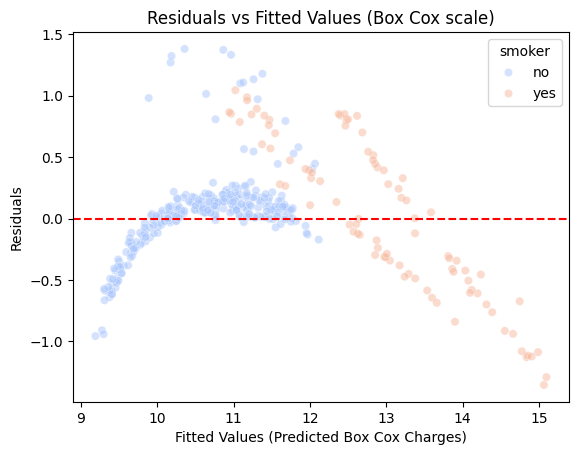

In [116]:
# Plot residuals vs fitted values
residuals = y_test - y_pred
sns.scatterplot(
    x=y_pred,
    y=residuals,
    hue=data_df.loc[y_test.index, 'smoker'],
    palette='coolwarm',
    alpha=0.5
)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Fitted Values (Predicted Box Cox Charges)')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values (Box Cox scale)')
plt.show()

Now that we have a baseline, we can explore more complex models and feature engineering techniques to improve performance.

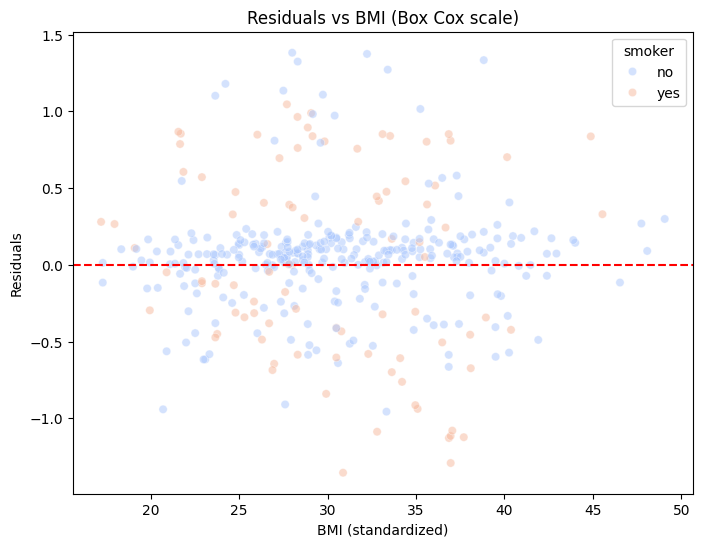

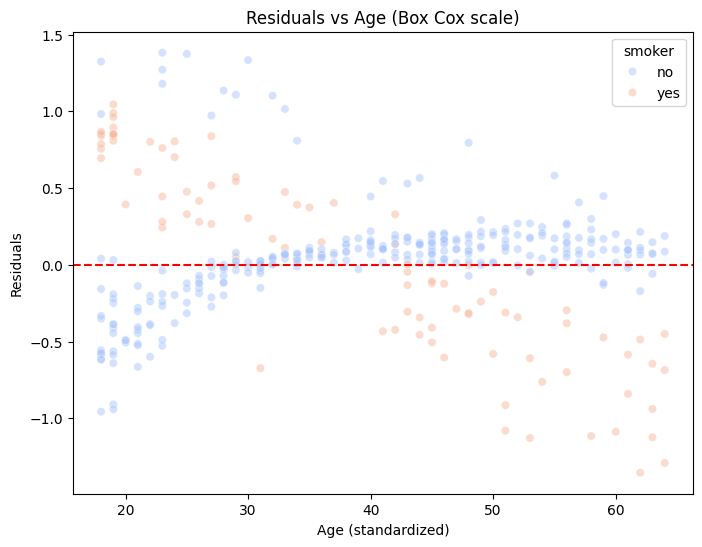

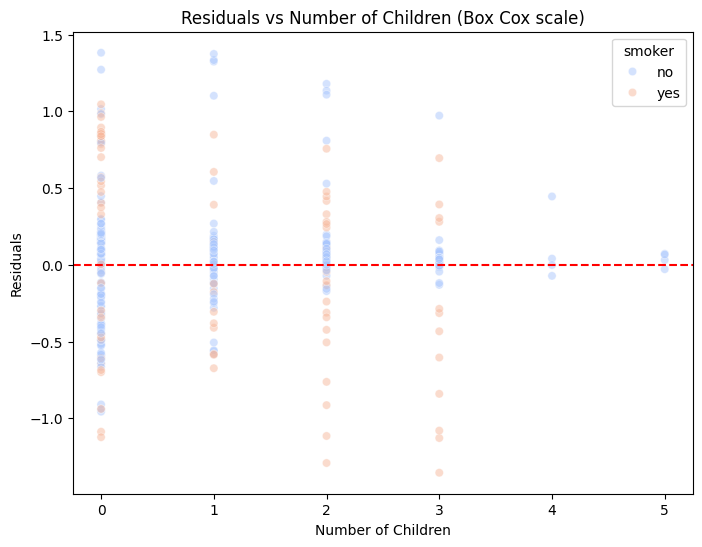

In [ ]:
# plot residuals vs numerical features colored by smoker status
#bmi
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data_df.loc[y_test.index, 'bmi'], y=residuals, hue=data_df.loc[y_test.index, 'smoker'], palette='coolwarm', alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('BMI')
plt.ylabel('Residuals')
plt.title('Residuals vs BMI (Box Cox scale)')
plt.show()
# age
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data_df.loc[y_test.index, 'age'], y=residuals, hue=data_df.loc[y_test.index, 'smoker'], palette='coolwarm', alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Age')
plt.ylabel('Residuals')
plt.title('Residuals vs Age (Box Cox scale)')
plt.show()
# children
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data_df.loc[y_test.index, 'children'], y=residuals, hue=data_df.loc[y_test.index, 'smoker'], palette='coolwarm', alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Number of Children')
plt.ylabel('Residuals')
plt.title('Residuals vs Number of Children (Box Cox scale)')
plt.show()

## 5. Advanced models

###  5.1 Adding interaction terms and running Linear Regression again

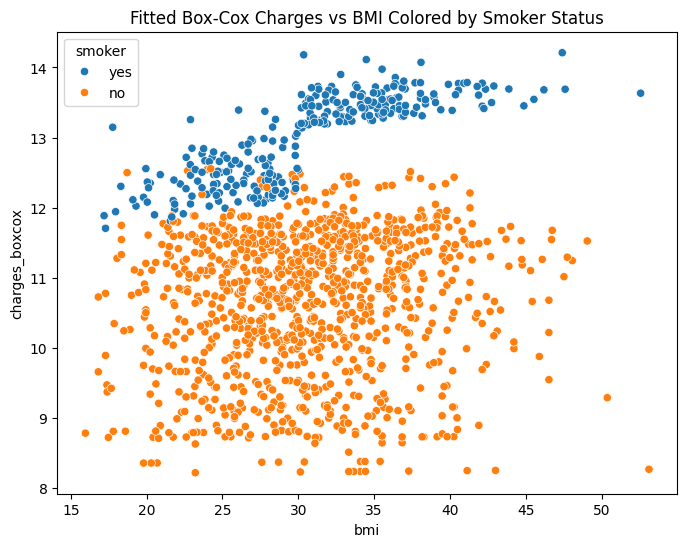

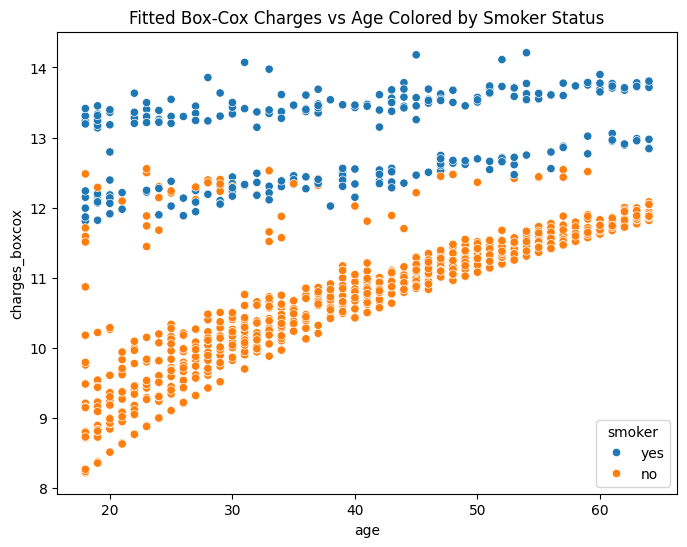

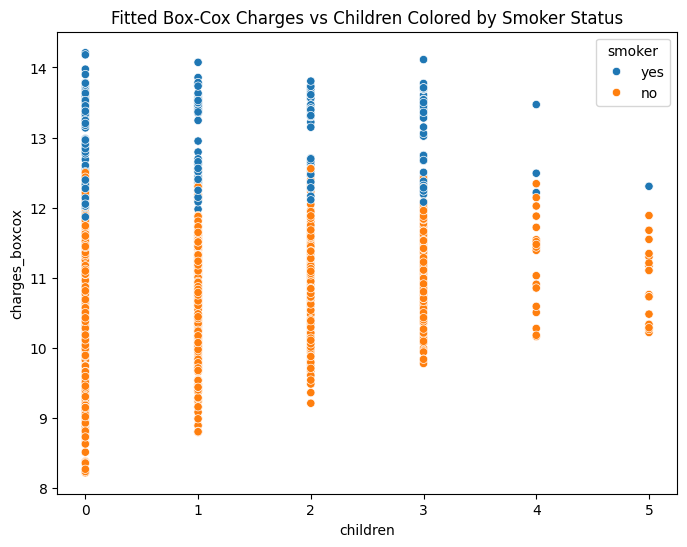

In [118]:
# Since smoker is the most important feature, plot a scatter plot of fitted charges vs each numerical feature colored by smoker status
plt.figure(figsize=(8, 6))
sns.scatterplot(x='bmi', y='charges_boxcox', hue='smoker', data=data_df)
plt.title('Fitted Box-Cox Charges vs BMI Colored by Smoker Status')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x='age', y='charges_boxcox', hue='smoker', data=data_df)
plt.title('Fitted Box-Cox Charges vs Age Colored by Smoker Status')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x='children', y='charges_boxcox', hue='smoker', data=data_df)
plt.title('Fitted Box-Cox Charges vs Children Colored by Smoker Status')
plt.show()

From plot of fitted charges vs bmi, we see a spike in charges for smokers with bmi>30, so considering a split in this group as a new feature and adding an interaction term between the new feature and smoker in the new model

In [119]:
data_df['high_bmi'] = (data_df['bmi'] > 30).astype(int)
data_df['high_bmi_smoker_interaction'] = data_df['high_bmi'] * ((data_df['smoker'] == 'yes').astype(int))
data_df['high_bmi_bmi_interaction'] = data_df['high_bmi'] * data_df['bmi']
data_df['bmi_smoker_interaction'] = data_df['bmi'] * ((data_df['smoker'] == 'yes').astype(int))
data_df.drop(['high_bmi'], axis=1, inplace=True)
# Re-define features and target variable with the new feature
X = data_df.drop(['charges', 'charges_boxcox'], axis=1)
y = data_df['charges_boxcox']
# One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)
# Use train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Use 10 fold cross-validation to evaluate the new model
model = LinearRegression()
mse_scores = -cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
r2_scores = cross_val_score(model, X_train, y_train, cv=10, scoring='r2')
print(f'Average MSE from 10-fold CV after adding feature: {mse_scores.mean():.6f}')
print(f'Average R² from 10-fold CV after adding feature: {r2_scores.mean():.6f}')
# Fit the new model on the training data
model.fit(X_train, y_train)
# Predict on the test data
y_pred= model.predict(X_test)
# scale back the predictions to original charges using inverse box-cox transformation
from scipy.special import inv_boxcox
y_pred_orig = inv_boxcox(y_pred, fitted_lambda)
y_test_orig = inv_boxcox(y_test, fitted_lambda)

# Evaluate the new model
mse = mean_squared_error(y_test_orig, y_pred_orig)
r2 = r2_score(y_test_orig, y_pred_orig)
print(f'Test MSE after adding feature: {mse:.6f}')
print(f'Test R² after adding feature: {r2:.6f}')

Average MSE from 10-fold CV after adding feature: 0.276886
Average R² from 10-fold CV after adding feature: 0.850012
Test MSE after adding feature: 64501598.459122
Test R² after adding feature: 0.548059


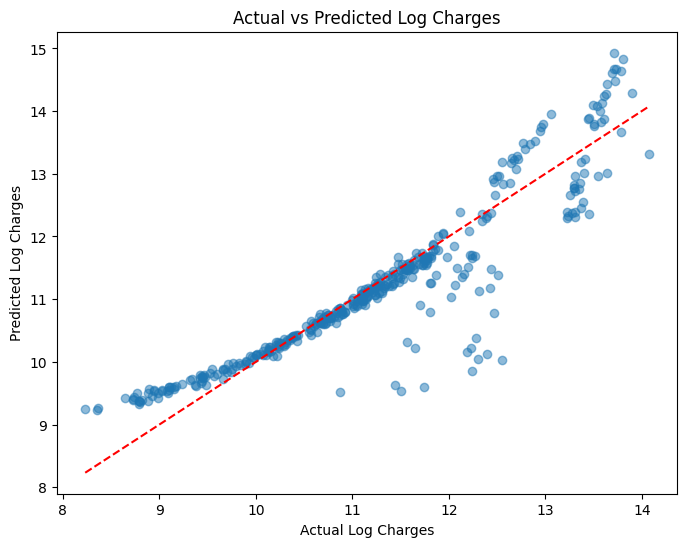

In [120]:
# Make a scatter plot of model predicted charges vs actual charges after adding the new feature
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Log Charges')
plt.ylabel('Predicted Log Charges')
plt.title('Actual vs Predicted Log Charges')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.show()

In [121]:
X_test.columns

Index(['age', 'bmi', 'children', 'high_bmi_smoker_interaction',
       'high_bmi_bmi_interaction', 'bmi_smoker_interaction', 'sex_male',
       'smoker_yes', 'region_northwest', 'region_southeast',
       'region_southwest'],
      dtype='object')

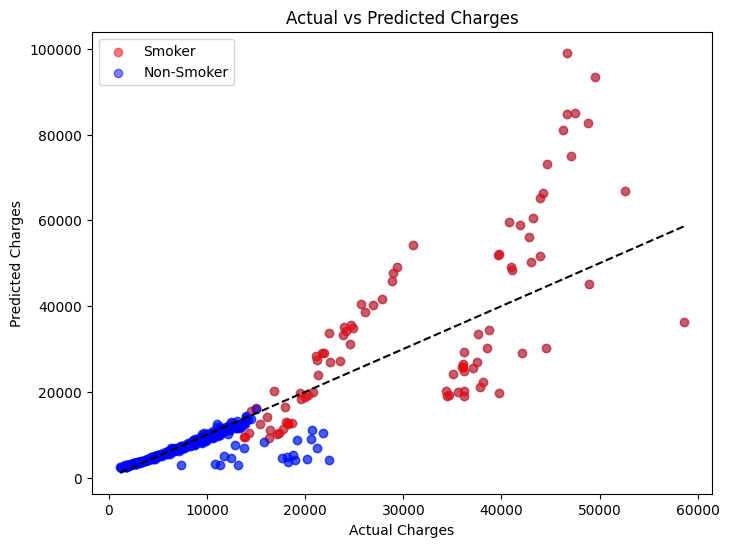

In [122]:
# Make a scatter plot of model predicted charges vs actual charges after adding the new feature
plt.figure(figsize=(8, 6))
plt.scatter(y_test_orig, y_pred_orig, alpha=0.5)
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Actual vs Predicted Charges')
# use smoker status to color the points
smoker_mask = X_test['smoker_yes'] == True
plt.scatter(y_test_orig[smoker_mask], y_pred_orig[smoker_mask], alpha=0.5, color='r', label='Smoker')
plt.scatter(y_test_orig[~smoker_mask], y_pred_orig[~smoker_mask], alpha=0.5, color='b', label='Non-Smoker')
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'k--')  # Diagonal line
plt.legend()
plt.show()

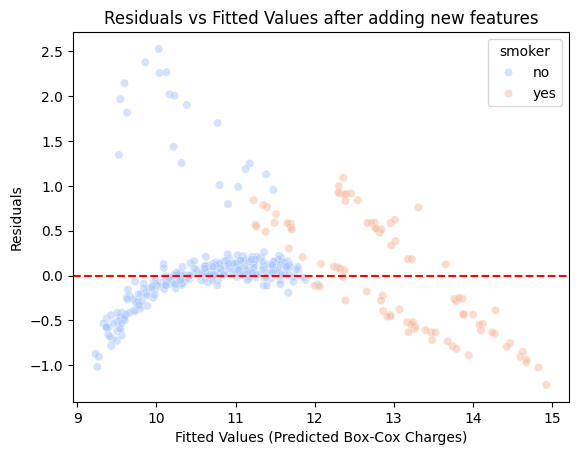

In [123]:
# Plot residuals vs fitted values
residuals = y_test - y_pred
sns.scatterplot(
    x=y_pred,
    y=residuals,
    hue=data_df.loc[y_test.index, 'smoker'],
    palette='coolwarm',
    alpha=0.5
)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Fitted Values (Predicted Box-Cox Charges)')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values after adding new features')
plt.show()

Slightly better fit with interaction term; but residuals still show distinct patterns so we're exploring polynomial terms next

### 5.2 Polynomial regression

In [124]:
# Poly regression
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)
# Use train-test split
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)
# Use 10 fold cross-validation to evaluate the polynomial regression model
model = LinearRegression()
mse_scores = -cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
r2_scores = cross_val_score(model, X_train, y_train, cv=10, scoring='r2')
print(f'Average MSE from 10-fold CV for poly: {mse_scores.mean():.6f}')
print(f'Average R² from 10-fold CV for poly: {r2_scores.mean():.6f}')
# Fit the polynomial regression model on the training data
model.fit(X_train, y_train)
# Predict on the test data
y_pred_poly = model.predict(X_test)
# Evaluate the polynomial regression model
mse = mean_squared_error(y_test, y_pred_poly)
r2 = r2_score(y_test, y_pred_poly)
print(f'Test MSE for poly: {mse:.6f}')
print(f'Test R² for poly: {r2:.6f}')

Average MSE from 10-fold CV for poly: 0.193855
Average R² from 10-fold CV for poly: 0.894566
Test MSE for poly: 0.180922
Test R² for poly: 0.894331


In [125]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# y_test and y_pred are Box-Cox transformed
y_test_orig = inv_boxcox(y_test, fitted_lambda)
y_pred_orig = inv_boxcox(y_pred, fitted_lambda)

mse_orig = mean_squared_error(y_test_orig, y_pred_orig)
rmse_orig = np.sqrt(mse_orig)
r2_orig = r2_score(y_test_orig, y_pred_orig)
print(f"MSE on original scale: {mse_orig}")
print(f"R2 on original scale: {r2_orig}")

MSE on original scale: 64501598.45912194
R2 on original scale: 0.5480585845658593


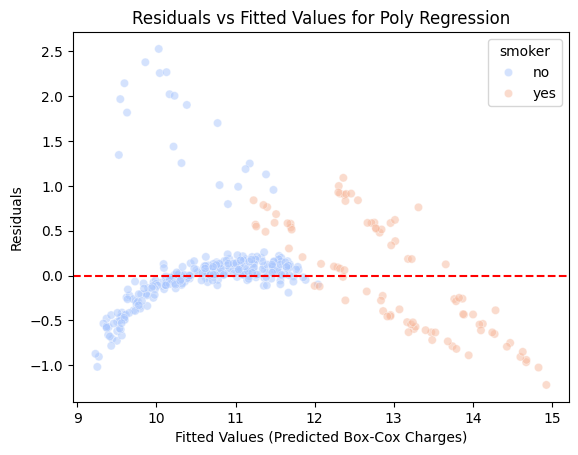

In [126]:
# Residuals vs Fitted plot (box cox scale)
import seaborn as sns
residuals_poly = y_test - y_pred
sns.scatterplot(
    x=y_pred,
    y=residuals_poly,
    hue=data_df.loc[y_test.index, 'smoker'],
    palette='coolwarm',
    alpha=0.5
)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Fitted Values (Predicted Box-Cox Charges)')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values for Poly Regression')
plt.show() 

Residuals < 0: 176
Residuals > 0: 212
Residuals mean: 0.0407
Residuals median: 0.0182
Skewness: 1.6544


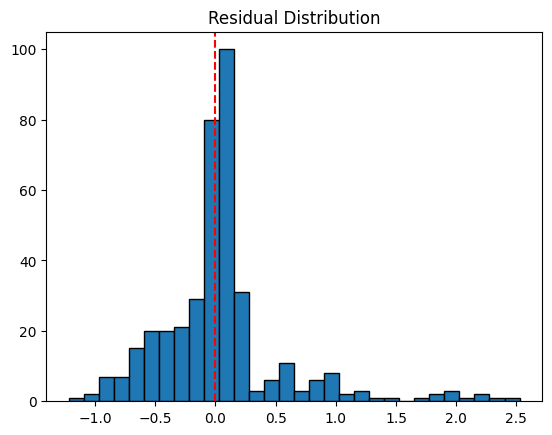

In [ ]:
# Quantify the asymmetry:
print(f"Residuals < 0: {(residuals_poly < 0).sum()}")
print(f"Residuals > 0: {(residuals_poly > 0).sum()}")
print(f"Residuals mean: {residuals_poly.mean():.4f}")  # Should be ~0
print(f"Residuals median: {residuals_poly.median():.4f}")  # Check skew
print(f"Skewness: {residuals_poly.skew():.4f}")  # Should be ~0

# Visual check:
plt.hist(residuals_poly, bins=30, edgecolor='black')
plt.axvline(0, color='red', linestyle='--')
plt.title('Residual Distribution')
plt.show()

As we have skewness in the residuals, we can try using robust regression models like XGBoost and LightGBM with robust loss functions like regression loss to see if they improve performance.

### 5.3 Ensemble learning methods

In [128]:
# Try using a Random Forest with hyperparameter tuning to see if we can improve the model performance
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
rf = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [10, 20, 50, 100, 200],
    'max_depth': range(3, 11, 1),
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
X = data_df.drop(['charges', 'charges_boxcox'], axis=1)
y = data_df['charges_boxcox']
# One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
cv_results = cross_validate(best_rf, X_train, y_train,
    cv=10,
    scoring=['r2', 'neg_mean_squared_error'],
    n_jobs=-1)
print(f'Average CV R²: {np.mean(cv_results["test_r2"]):.6f}')
print(f'Average CV MSE: {-np.mean(cv_results["test_neg_mean_squared_error"]):.6f}')
# Predict on the test data using the best Random Forest model
y_pred_rf = best_rf.predict(X_test)
y_pred_rf_orig = inv_boxcox(y_pred_rf, fitted_lambda)
# Evaluate the Random Forest model
mse_rf = mean_squared_error(y_test_orig, y_pred_rf_orig)
r2_rf = r2_score(y_test_orig, y_pred_rf_orig)
print(f'Random Forest Test MSE: {mse_rf:.6f}')
print(f'Random Forest Test R²: {r2_rf:.6f}')

Average CV R²: 0.880510
Average CV MSE: 0.218143
Random Forest Test MSE: 9536143.947797
Random Forest Test R²: 0.933183


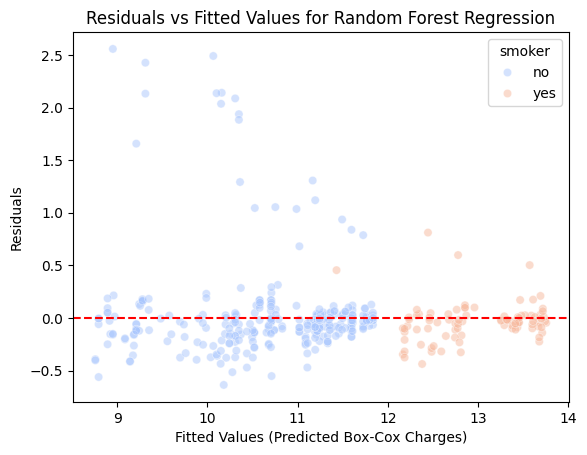

In [129]:
#Plot residuals vs fitted values for Random Forest
residuals_rf = y_test - y_pred_rf
sns.scatterplot(
    x=y_pred_rf,
    y=residuals_rf,
    hue=data_df.loc[y_test.index, 'smoker'],
    palette='coolwarm',
    alpha=0.5
)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Fitted Values (Predicted Box-Cox Charges)')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values for Random Forest Regression')
plt.show()

In [130]:
# Scale back the predictions to original charges using inverse box-cox transformation
y_pred_orig = inv_boxcox(y_pred, fitted_lambda)
y_test_orig = inv_boxcox(y_test, fitted_lambda)
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
r2 = r2_score(y_test_orig, y_pred_orig)
print(f'RMSE on original scale: {rmse:.6f}')
print(f'R² on original scale: {r2:.6f}')

RMSE on original scale: 8031.288717
R² on original scale: 0.548059


In [131]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Features and target
X = data_df.drop(['charges', 'charges_boxcox'], axis=1)
y = data_df['charges']

# Clip extreme values to stabilize metrics (optional)
lower_cap = y.quantile(0.025)
upper_cap = y.quantile(0.975)
y_clipped = y.clip(lower=lower_cap, upper=upper_cap)

# Log-transform the target to reduce skew
y_log = np.log1p(y_clipped)  # log(1 + charges)

# One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.3, random_state=42)


import lightgbm as lgb

# Create datasets
lgb_train = lgb.Dataset(X_train, y_train_log)
lgb_eval = lgb.Dataset(X_test, y_test_log, reference=lgb_train)

# Parameters
params = {
    'objective': 'huber',      # robust to outliers
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbose': -1
}

# Train
gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=500,
    valid_sets=[lgb_eval]
)


LightGBM Test RMSE: 3108.68
LightGBM Test R²: 0.929313
LightGBM Test MAE: 1438.63
LightGBM Test Median AE: 482.49


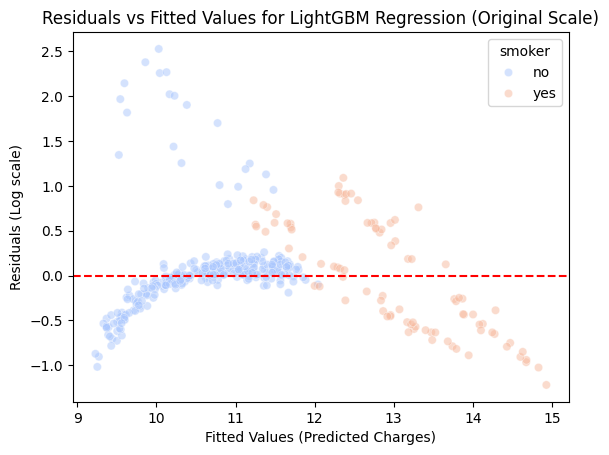

In [ ]:
# Predict on log scale
y_pred_log = gbm.predict(X_test, num_iteration=gbm.best_iteration)

# Invert log-transform to get original charges
y_pred_orig = np.expm1(y_pred_log)  # exp(pred) - 1
y_test_orig = np.expm1(y_test_log)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error

mse = mean_squared_error(y_test_orig, y_pred_orig)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_orig, y_pred_orig)
mae = mean_absolute_error(y_test_orig, y_pred_orig)
medae = median_absolute_error(y_test_orig, y_pred_orig)

print(f"LightGBM Test RMSE: {rmse:.2f}")
print(f"LightGBM Test R²: {r2:.6f}")
print(f"LightGBM Test MAE: {mae:.2f}")
print(f"LightGBM Test Median AE: {medae:.2f}")
# Plot residuals vs fitted values for LightGBM
import matplotlib.pyplot as plt
import seaborn as sns

residuals = y_test_log - y_pred_log

# color by smoker status
sns.scatterplot(
    x=y_pred_log,
    y=residuals,
    hue=data_df.loc[y_test.index, 'smoker'],
    palette='coolwarm',
    alpha=0.5
)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Fitted Values (Log scale)')
plt.ylabel('Residuals (Log scale)')
plt.title('Residuals vs Fitted Values for LightGBM Regression (Log Scale)')
plt.show()

<Axes: xlabel='charges', ylabel='Count'>

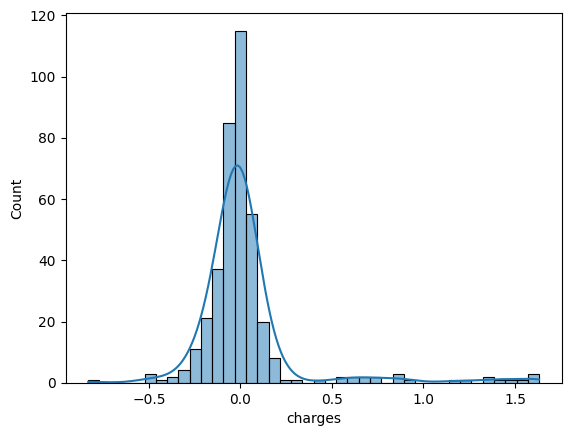

In [133]:
# Plot log based residuals for LightGBM
residuals_log = y_test_log - y_pred_log
sns.histplot(residuals_log, kde=True)


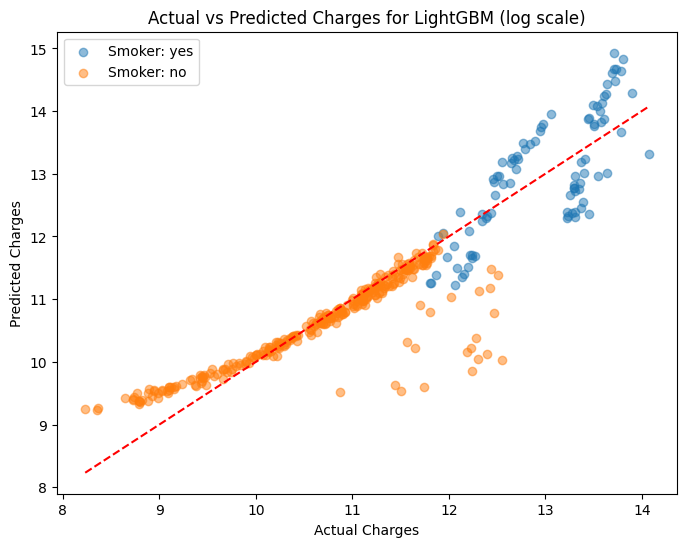

In [ ]:
# Plot predicted vs actual charges for LightGBM, color coded by smoker status
plt.figure(figsize=(8, 6))
for s in ['yes', 'no']:
    mask = (data_df.loc[y_test.index, 'smoker'] == s)
    plt.scatter(y_test_log[mask], y_pred_log[mask], alpha=0.5, label=f'Smoker: {s}')
plt.xlabel('Actual Charges (Log scale)')
plt.ylabel('Predicted Charges (Log scale)')
plt.title('Actual vs Predicted Charges for LightGBM (log scale)')
plt.plot([y_test_log.min(), y_test_log.max()], [y_test_log.min(), y_test_log.max()], 'r--')  # Diagonal line
plt.legend()
plt.show()

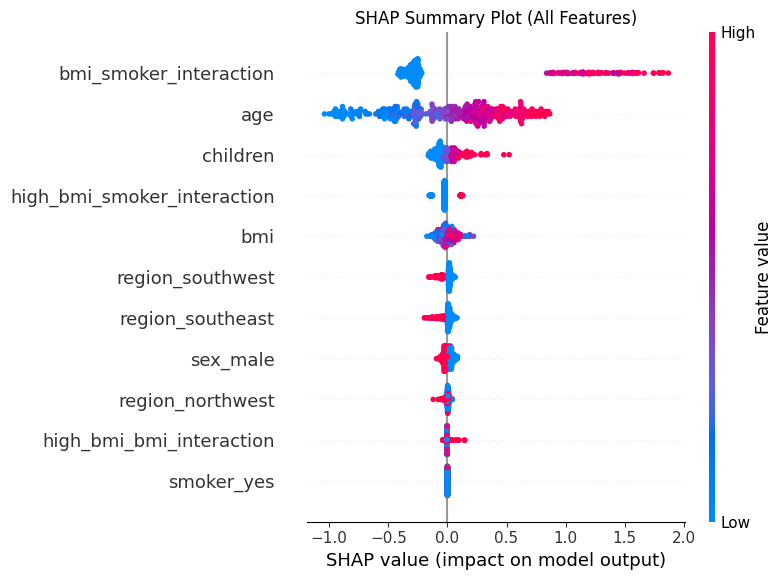

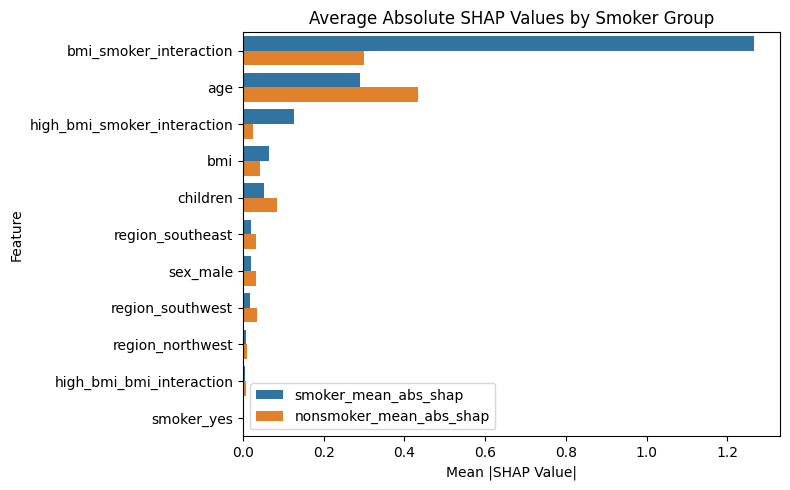

In [135]:
# ======================================
# 🔍 SHAP Analysis for Joint LightGBM Model
# ======================================

import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Reuse your trained LightGBM model (gbm), test data (X_test, y_test_log)
# and ensure X_test has the same columns as used in training

# Initialize SHAP TreeExplainer for LightGBM
explainer = shap.TreeExplainer(gbm)

# Compute SHAP values for test set
shap_values = explainer.shap_values(X_test)

# Convert predictions back to original scale
y_pred_log = gbm.predict(X_test)
y_pred_orig = np.expm1(y_pred_log)
y_test_orig = np.expm1(y_test_log)

# ===============================
# 1️⃣ Global Feature Importance
# ===============================
plt.title("SHAP Summary Plot (All Features)")
shap.summary_plot(shap_values, X_test, show=False)
plt.tight_layout()
plt.show()

# ===============================
# 3️⃣ Smoker vs Non-Smoker SHAP Comparison
# ===============================
if 'smoker_yes' in X_test.columns:
    smoker_mask = X_test['smoker_yes'] == 1
    nonsmoker_mask = X_test['smoker_yes'] == 0

    mean_abs_shap_smoker = np.abs(shap_values[smoker_mask]).mean(axis=0)
    mean_abs_shap_nonsmoker = np.abs(shap_values[nonsmoker_mask]).mean(axis=0)

    shap_diff_df = pd.DataFrame({
        'feature': X_test.columns,
        'smoker_mean_abs_shap': mean_abs_shap_smoker,
        'nonsmoker_mean_abs_shap': mean_abs_shap_nonsmoker
    }).sort_values(by='smoker_mean_abs_shap', ascending=False)

    plt.figure(figsize=(8, 5))
    sns.barplot(
        data=shap_diff_df.melt(id_vars='feature', var_name='group', value_name='mean_abs_shap'),
        x='mean_abs_shap', y='feature', hue='group'
    )
    plt.title('Average Absolute SHAP Values by Smoker Group')
    plt.xlabel('Mean |SHAP Value|')
    plt.ylabel('Feature')
    plt.legend(title='')
    plt.tight_layout()
    plt.show()

XGBoost Test MSE: 9698330.85
XGBoost Test R²: 0.929061
XGBoost Test MAE: 1503.49
XGBoost Test Median AE: 516.20


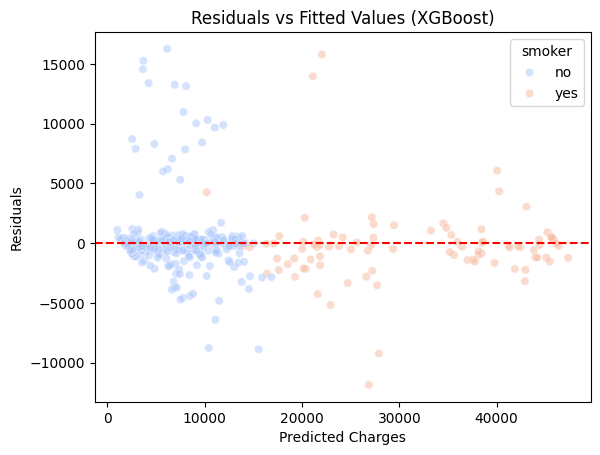

In [136]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# ===============================
# 1️⃣ Prepare features and target
# ===============================
X = data_df.drop(['charges', 'charges_boxcox'], axis=1)  # keep smoker
y = data_df['charges']

# Optional: clip extreme charges for stability
lower_cap = y.quantile(0.025)
upper_cap = y.quantile(0.975)
y_clipped = y.clip(lower=lower_cap, upper=upper_cap)

# One-hot encode categorical variables (smoker etc.)
X = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_clipped, test_size=0.3, random_state=42
)

# Ensure numeric columns only
X_train = X_train.astype(float)
X_test = X_test.astype(float)

# Align columns just in case
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# ===============================
# 2️⃣ Define XGBoost model
# ===============================
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',  # stable for large targets
    learning_rate=0.05,
    n_estimators=500,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# ===============================
# 3️⃣ Train
# ===============================
xgb_model.fit(X_train, y_train)

# ===============================
# 4️⃣ Predict
# ===============================
y_pred = xgb_model.predict(X_test)

# ===============================
# 5️⃣ Metrics
# ===============================
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)

print(f"XGBoost Test MSE: {mse:.2f}")
print(f"XGBoost Test R²: {r2:.6f}")
print(f"XGBoost Test MAE: {mae:.2f}")
print(f"XGBoost Test Median AE: {medae:.2f}")

# ===============================
# 6️⃣ Residual plot
# ===============================
residuals = y_test - y_pred

sns.scatterplot(
    x=y_pred,
    y=residuals,
    hue=data_df.loc[y_test.index, 'smoker'],
    palette='coolwarm',
    alpha=0.5
)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted Charges')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values (XGBoost)')
plt.show()


The LightGBM algorithm has the best R2 of all algorithms so far.